# Training notebook
# Time frequency plots for Probability learning


In [1]:
import os.path as op

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
#from mne.datasets import somato
import copy

import os

# Для одного испытуемого

In [14]:
subj = 'P001'
r = 2
cond = 'risk'
fb = 'negative'

L_freq = 2
H_freq = 40
f_step = 1
freqs = np.arange(L_freq, H_freq, f_step)
#for others
n_cycles = freqs//2

period_start = -1.750
period_end = 2.750

baseline = (-0.35, -0.05)

data_path = '/net/server/data/Archive/prob_learn/vtretyakova/ICA_cleaned'


In [10]:
events_pos = np.loadtxt("/net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/fix_cross_mio_corr/{0}_run{1}_norisk_fb_cur_positive_fix_cross.txt".format(subj, r), dtype='int') 
if events_pos.shape == (3,):
    events_pos = events_pos.reshape(1,3)
        

In [11]:
events_neg = np.loadtxt("/net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/fix_cross_mio_corr/{0}_run{1}_norisk_fb_cur_negative_fix_cross.txt".format(subj, r), dtype='int')
if events_neg.shape == (3,):
    events_neg = events_neg.reshape(1,3) 

In [12]:
#объединяем негативные и позитивные фидбеки для получения общего бейзлайна по ним, и сортируем массив, чтобы времена меток шли в порядке возрастания    
events = np.vstack([events_pos, events_neg])
events = np.sort(events, axis = 0) 

In [13]:
#events, which we need
events_response = np.loadtxt('/net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/events_by_cond_mio_corrected/{0}_run{1}_{2}_fb_cur_{3}.txt'.format(subj, r, cond, fb), dtype='int')
# если только одна метка, т.е. одна эпоха, то выдается ошибка, поэтому приводи shape к виду (N,3)
if events_response.shape == (3,):
    events_response = events_response.reshape(1,3)

In [15]:
raw_fname = op.join(data_path, '{0}/run{1}_{0}_raw_ica.fif'.format(subj, r))

raw_data = mne.io.Raw(raw_fname, preload=True)
        
    
picks = mne.pick_types(raw_data.info, meg = True, eog = True)

Opening raw data file /net/server/data/Archive/prob_learn/vtretyakova/ICA_cleaned/P001/run2_P001_raw_ica.fif...
    Range : 154000 ... 303999 =    154.000 ...   303.999 secs
Ready.
Reading 0 ... 149999  =      0.000 ...   149.999 secs...


<ipython-input-15-7dd5835ff470>:3: RuntimeWarning: This filename (/net/server/data/Archive/prob_learn/vtretyakova/ICA_cleaned/P001/run2_P001_raw_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_data = mne.io.Raw(raw_fname, preload=True)


In [119]:
#epochs for baseline
    # baseline = None, чтобы не вычитался дефолтный бейзлайн
epochs = mne.Epochs(raw_data, events, event_id = None, tmin = -1.0, tmax = 1.0, baseline = None, picks = picks, preload = True)
epochs.resample(300)

Not setting metadata
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 2001 original time points ...
0 bad epochs dropped


<Epochs |  25 events (all good), -1 - 0.996667 sec, baseline off, ~40.2 MB, data loaded,
 '1': 25>

In [120]:
freq_show_baseline = mne.time_frequency.tfr_multitaper(epochs, freqs = freqs, n_cycles = n_cycles, use_fft = False, return_itc = False, average=False).crop(tmin=baseline[0], tmax=baseline[1], include_tmax=True) #frequency of baseline

Not setting metadata


In [42]:
freq_show_baseline.data.shape

(25, 306, 38, 91)

In [44]:
b_line = np.swapaxes(freq_show_baseline.data, 0, 1)
b_line = np.swapaxes(b_line, 1, 2)
b_line.shape

(306, 38, 25, 91)

In [45]:
# выстраиваем в ряд бейзлайныbeta_16_30_epo_comb_planar для каждого из эвентов, как будто они происходили один за другим
a, b, c, d = b_line.shape
b_line = b_line.reshape(a, b, c * d)
b_line.shape

(306, 38, 2275)

In [46]:
####### ДЛЯ ДАННЫХ ##############
# baseline = None, чтобы не вычитался дефолтный бейзлайн
epochs = mne.Epochs(raw_data, events_response, event_id = None, tmin = period_start, 
		                tmax = period_end, baseline = None, picks = picks, preload = True)
		       
epochs.resample(300) 

freq_show = mne.time_frequency.tfr_multitaper(epochs, freqs = freqs, n_cycles = n_cycles, use_fft = False, return_itc = False, average=False)

Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Loading data for 2 events and 4501 original time points ...
0 bad epochs dropped
Not setting metadata


In [47]:
freq_show.data.shape

(2, 306, 38, 1350)

In [66]:
####### Для данных так же меняем оси местами
data = np.swapaxes(freq_show.data, 0, 1)
data.shape

(306, 2, 38, 1350)

In [67]:
data = np.swapaxes(data, 1, 2)
data.shape

(306, 38, 2, 1350)

In [68]:
data = np.swapaxes(data, 2, 3)
data.shape

(306, 38, 1350, 2)

- 2 number of epochs
- 306 - number of channels  
- 38 - number of frequances
- 1350 - number of time points

In [51]:
# Усредняем бейзлайн по всем точкам, получаем одно число (которое будем вычитать из data для каждого канала)
	    
b = b_line.mean(axis=-1)
	    
b.shape

(306, 38)

In [53]:
b_line_new_shape = b[:, :, np.newaxis, np.newaxis]
b_line_new_shape.shape


(306, 38, 1, 1)

In [69]:
data = 10*np.log10(data/b_line_new_shape)

In [70]:

data.shape

(306, 38, 1350, 2)

In [71]:
data = np.swapaxes(data, 2, 3)
data = np.swapaxes(data, 1, 2)
data = np.swapaxes(data, 0, 1)
data.shape

(2, 306, 38, 1350)

In [72]:
freq_show.data = data

In [73]:
freq_show.save('/home/vtretyakova/Рабочий стол/time_frequency_plots/train.h5', overwrite=True)

In [121]:
tfr = mne.time_frequency.read_tfrs('/home/vtretyakova/Рабочий стол/time_frequency_plots/train.h5', condition=None)
tfr1 = tfr[0]

Reading /home/vtretyakova/Рабочий стол/time_frequency_plots/train.h5 ...


<ipython-input-121-8a21db87eb53>:1: RuntimeWarning: This filename (/home/vtretyakova/Рабочий стол/time_frequency_plots/train.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  tfr = mne.time_frequency.read_tfrs('/home/vtretyakova/Рабочий стол/time_frequency_plots/train.h5', condition=None)


Not setting metadata


In [87]:
tfr

[<EpochsTFR | time : [-1.750000, 2.746667], freq : [2.000000, 39.000000], epochs : 2, channels : 306, ~244.9 MB>]

In [88]:
tfr1

<EpochsTFR | time : [-1.750000, 2.746667], freq : [2.000000, 39.000000], epochs : 2, channels : 306, ~244.9 MB>

In [77]:
tfr1.data.shape

(2, 306, 38, 1350)

In [122]:
tfr_ave = tfr1.data.mean(axis = 0)


In [123]:
tfr_ave = tfr_ave[np.newaxis, :, :, :]
tfr_ave.shape

(1, 306, 38, 1350)

In [124]:
tfr1.data = tfr_ave

In [125]:
tfr1.save('/home/vtretyakova/Рабочий стол/time_frequency_plots/train_ave.h5', overwrite=True)

In [126]:
ave = mne.time_frequency.read_tfrs('/home/vtretyakova/Рабочий стол/time_frequency_plots/train_ave.h5', condition=None)


Reading /home/vtretyakova/Рабочий стол/time_frequency_plots/train_ave.h5 ...


<ipython-input-126-4a8204e14aff>:1: RuntimeWarning: This filename (/home/vtretyakova/Рабочий стол/time_frequency_plots/train_ave.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  ave = mne.time_frequency.read_tfrs('/home/vtretyakova/Рабочий стол/time_frequency_plots/train_ave.h5', condition=None)


Not setting metadata


In [127]:
ave1 = ave[0]

In [129]:
ep_TFR_planar1 = ave1.copy(); 
ep_TFR_planar2 = ave1.copy()
ep_TFR_planar1.pick_types(meg='planar1')
ep_TFR_planar2.pick_types(meg='planar2')

#grad_RMS = np.power((np.power(evk_planar1.data, 2) + np.power(evk_planar2.data, 2)), 1/2)
combine = ep_TFR_planar1.data + ep_TFR_planar2.data

In [130]:
donor = mne.time_frequency.read_tfrs('/home/vtretyakova/Рабочий стол/time_frequency_plots/donor_combined_planars.h5', condition=None)[0]


Reading /home/vtretyakova/Рабочий стол/time_frequency_plots/donor_combined_planars.h5 ...


<ipython-input-130-19ceda72e319>:1: RuntimeWarning: This filename (/home/vtretyakova/Рабочий стол/time_frequency_plots/donor_combined_planars.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  donor = mne.time_frequency.read_tfrs('/home/vtretyakova/Рабочий стол/time_frequency_plots/donor_combined_planars.h5', condition=None)[0]


Not setting metadata


In [131]:
donor.data = combine

In [132]:
donor.save('/home/vtretyakova/Рабочий стол/time_frequency_plots/comb_planar_train_evoked.h5', overwrite=True)

In [ ]:
donor = mne.time_frequency.read_tfrs('/home/vtretyakova/Рабочий стол/time_frequency_plots/comb_planar_train_evoked.h5', condition=None)[0]

In [133]:
evoked = donor.average()


In [106]:
title = 'train'

No baseline correction applied


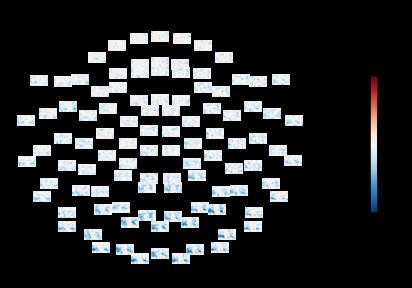

In [134]:
fig = evoked.plot_topo(baseline=None, tmin = -0.8, tmax = 2.4, picks = 'planar1', title = title, show = True, font_color='k');

In [136]:
fig.savefig('/home/vtretyakova/Рабочий стол/time_frequency_plots/train_TF_plots_comb.pdf', dpi=1200, format='pdf', transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None)

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  """Entry point for launching an IPython kernel.


In [164]:
evoked.data[82].shape

(38, 1350)

In [167]:
m = evoked.data[82].mean(axis = 1)
m

array([-2.19850049, -2.02254812, -1.12189728, -1.12109042, -0.33625798,
       -0.96068205, -1.27798424, -2.04418809, -3.27156361, -3.46355526,
       -4.03190489, -4.29762525, -4.28919934, -4.64388391, -4.70135074,
       -3.92411831, -3.90001658, -4.62459461, -4.57138006, -4.22238182,
       -3.88724517, -3.47169083, -4.63446291, -5.05464923, -5.29075583,
       -5.77730516, -5.79556846, -5.86303372, -5.20168292, -4.14432689,
       -2.79585285, -1.24404943, -0.78825786, -0.36032696,  0.34502931,
       -0.35578474, -0.48931275, -0.7231764 ])

In [168]:
m = m.mean()
m

-3.0672940998271003

In [198]:
binary_mask = np.empty(evoked.data[82].shape)

for i in range(evoked.data[82].shape[0]):
    list_freq = evoked.data[82][i].tolist()
    b = []
    for l in list_freq:
        if abs(l) > 6:
            b.append(1)
        else:
            b.append(0)
    binary_mask[i] = b
    
binary_mask = binary_mask.astype(np.int)

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


In [196]:
binary_mask.shape

(38, 1350)

In [194]:
evoked.data[82].shape

(38, 1350)

No baseline correction applied


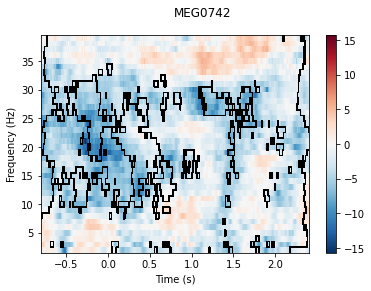

In [200]:
b = evoked.plot([82], baseline=None, tmin = -0.8, tmax = 2.4, title=tfr1.ch_names[82], show = True, mask = binary_mask, mask_style = 'contour');

In [ ]:
b = evoked.plot([82], baseline=None, tmin = -0.8, tmax = 2.4, title=tfr1.ch_names[82], show = True);

No baseline correction applied


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  """


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No basel

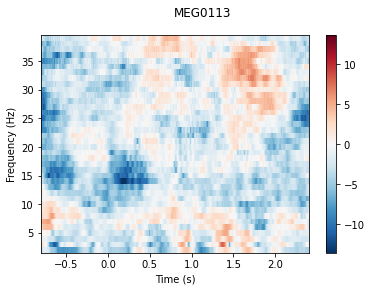

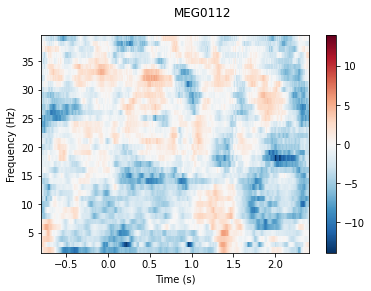

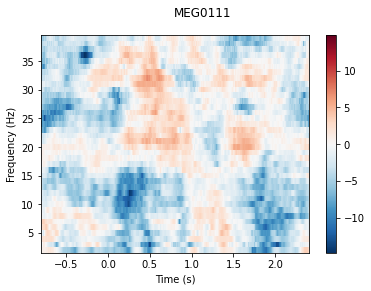

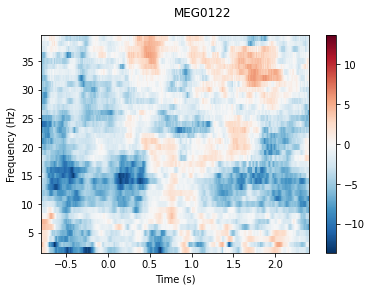

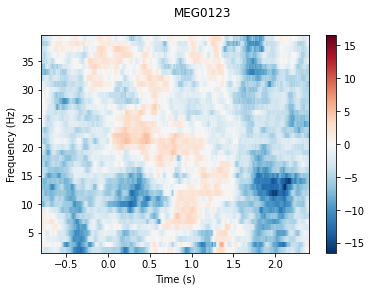

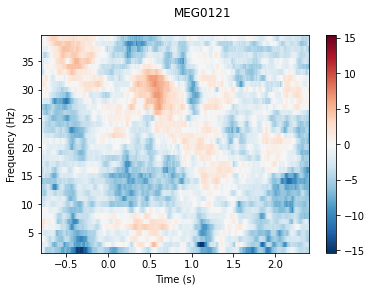

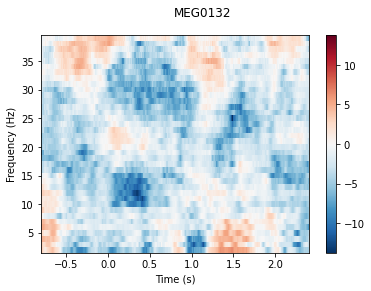

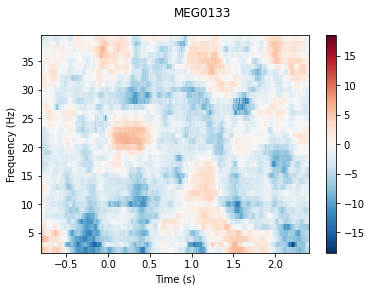

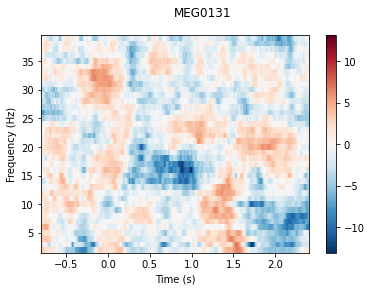

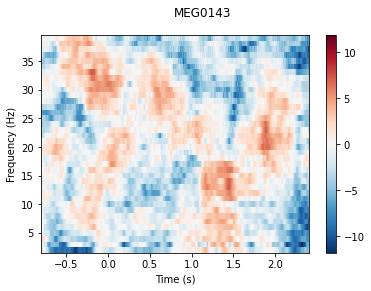

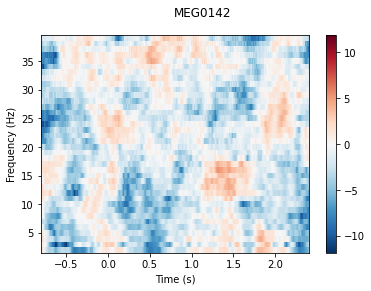

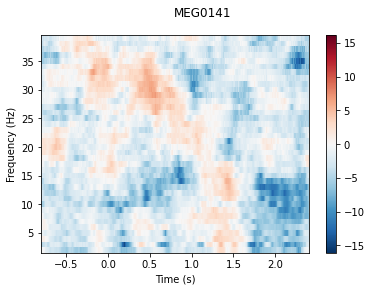

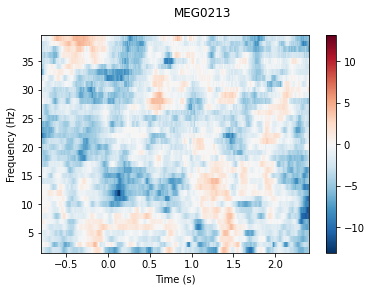

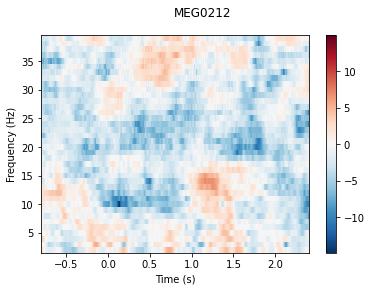

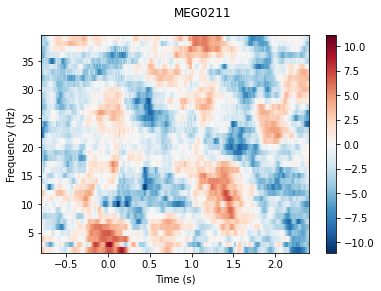

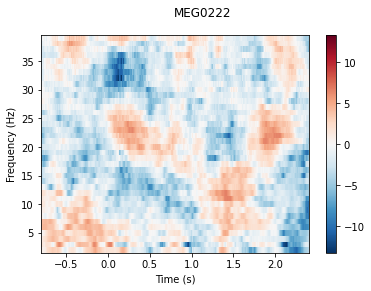

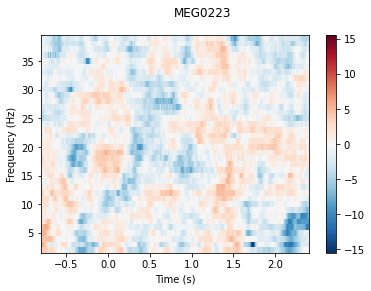

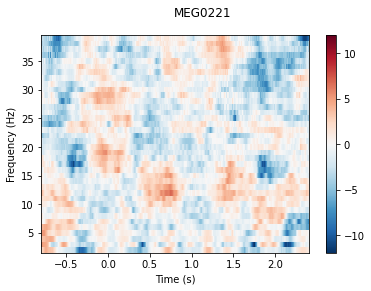

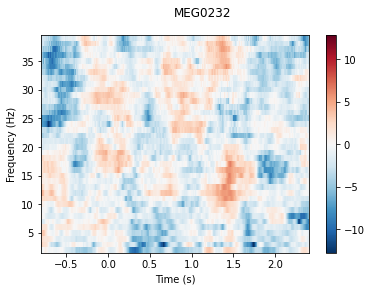

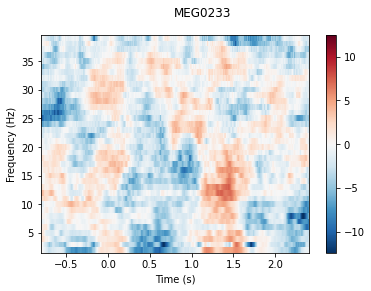

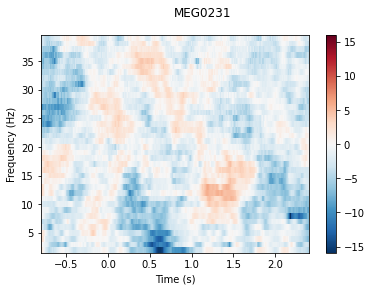

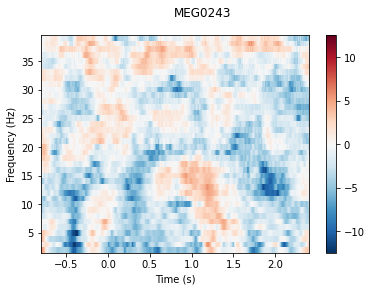

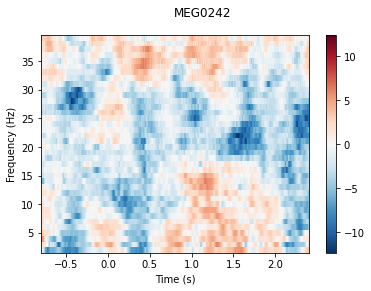

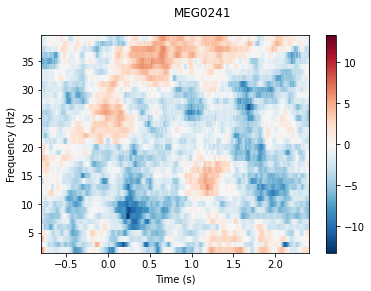

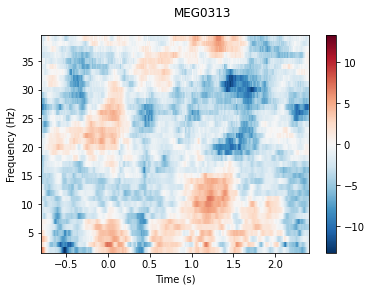

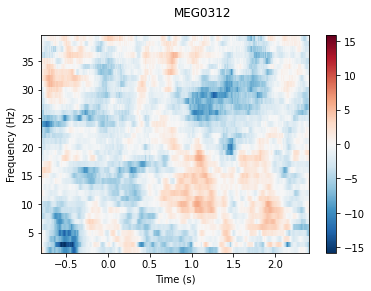

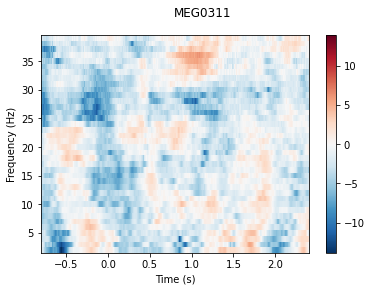

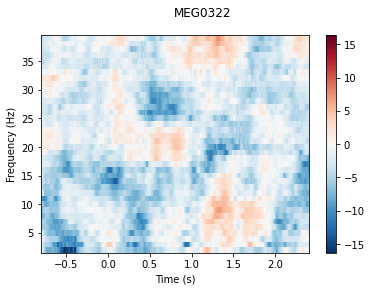

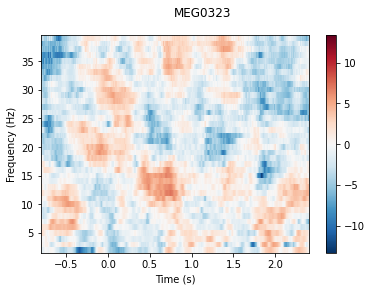

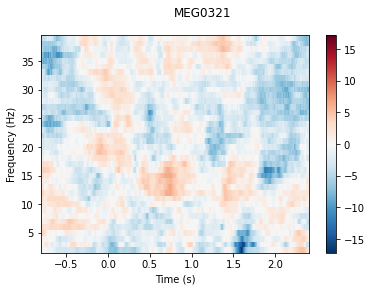

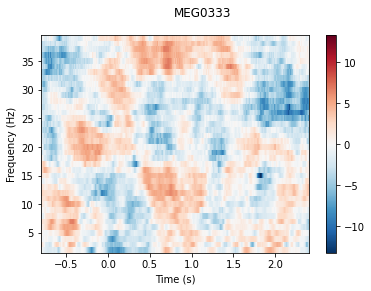

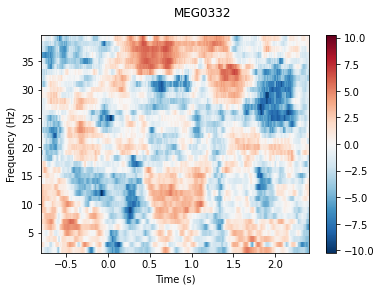

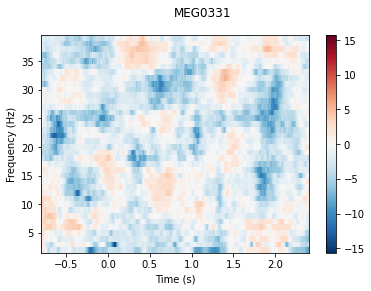

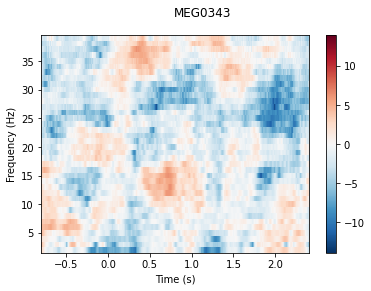

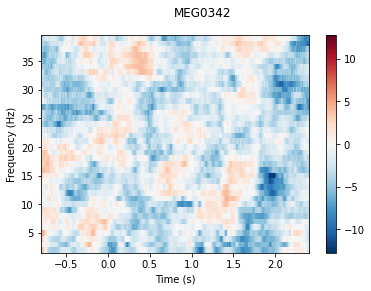

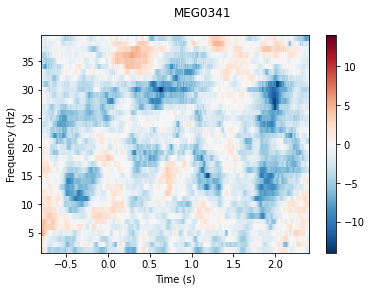

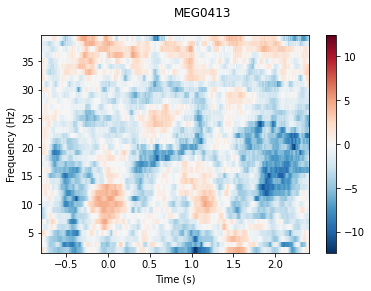

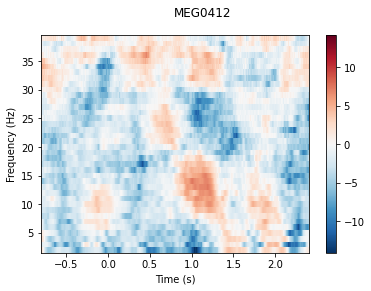

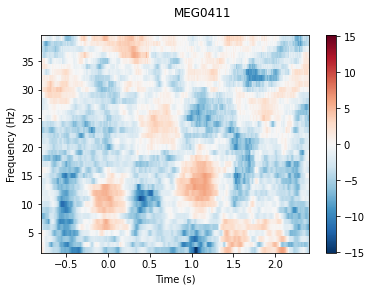

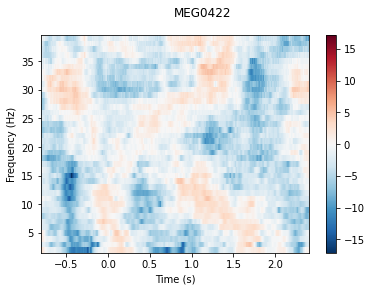

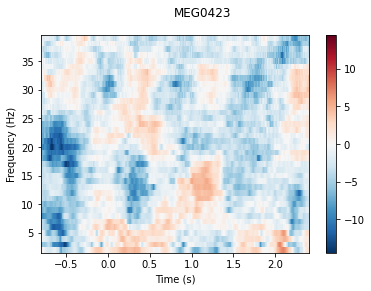

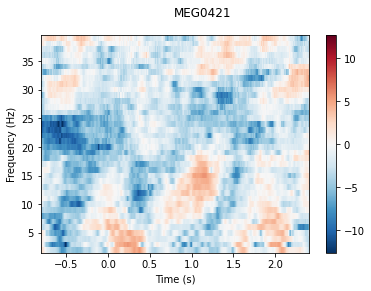

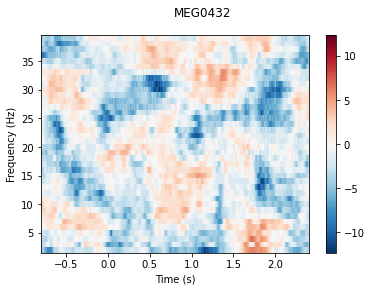

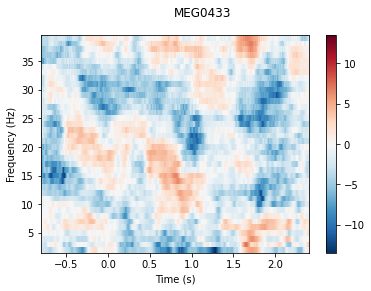

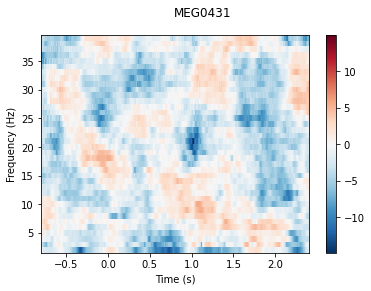

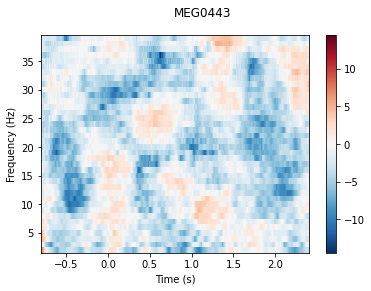

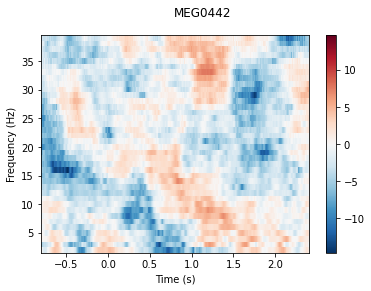

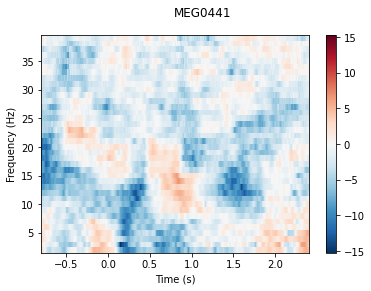

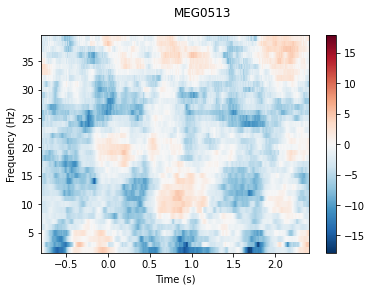

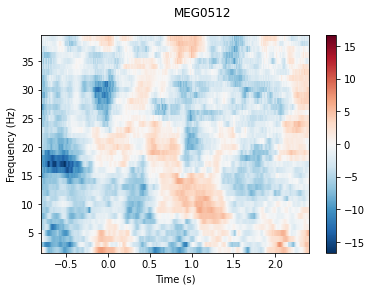

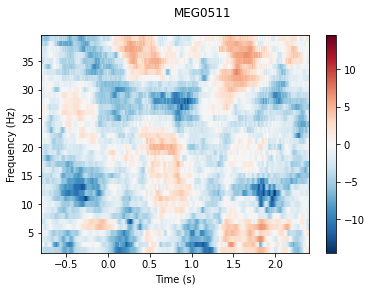

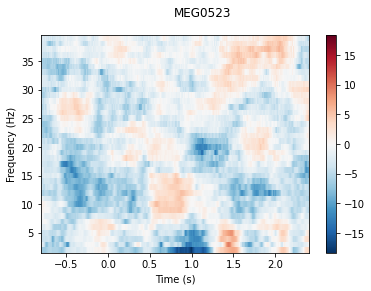

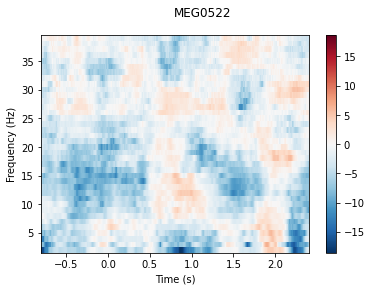

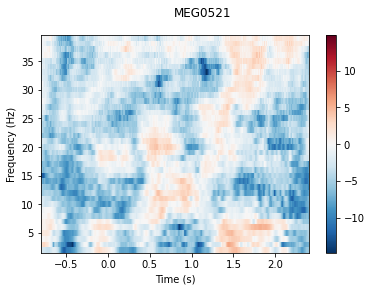

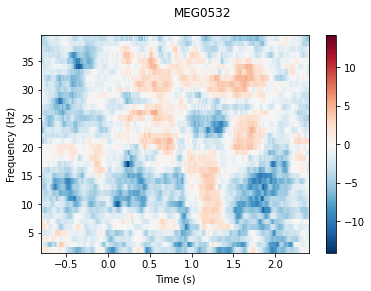

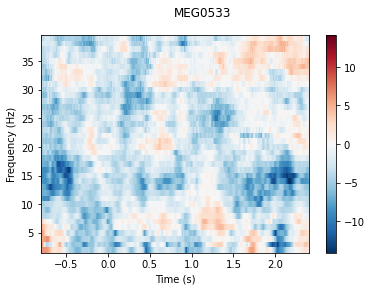

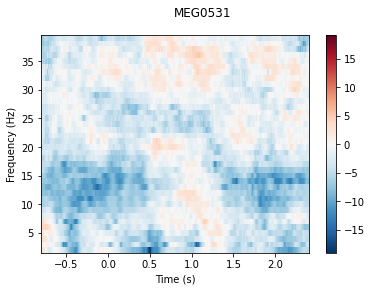

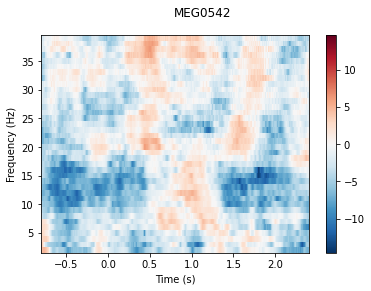

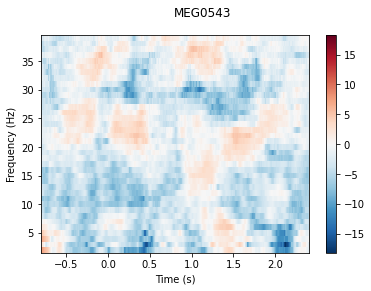

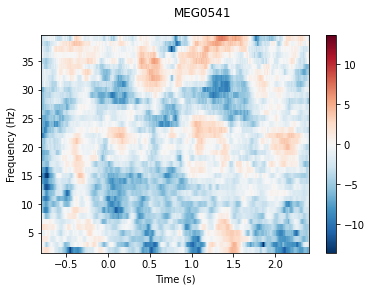

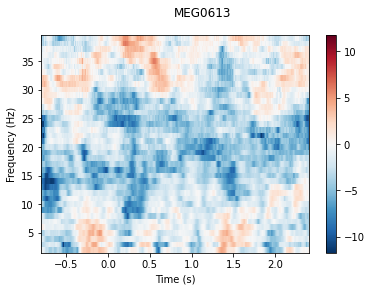

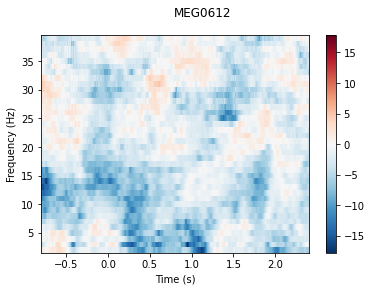

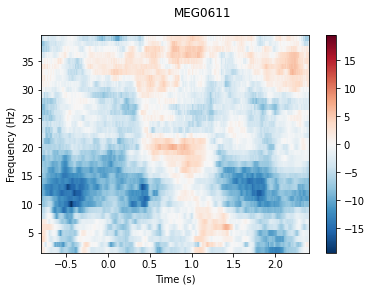

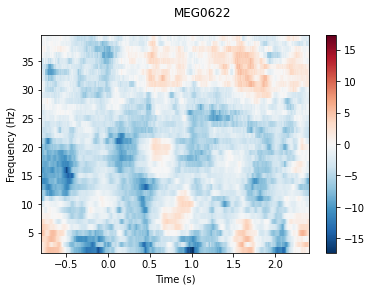

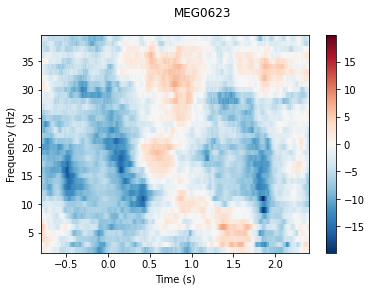

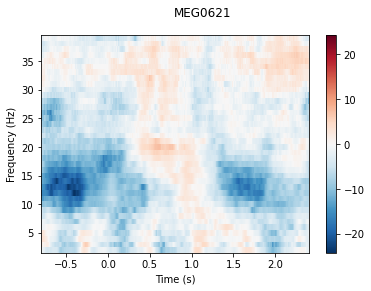

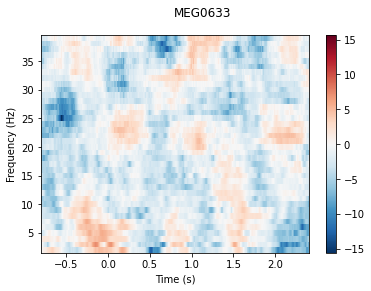

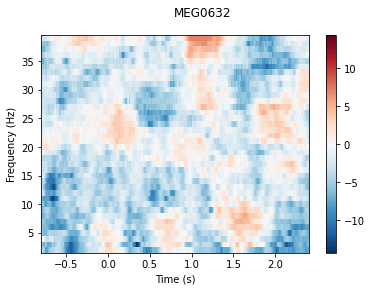

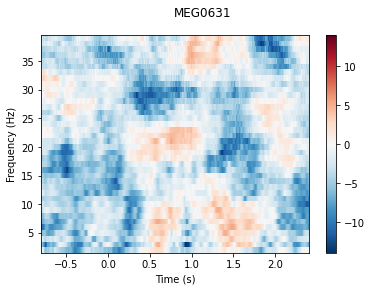

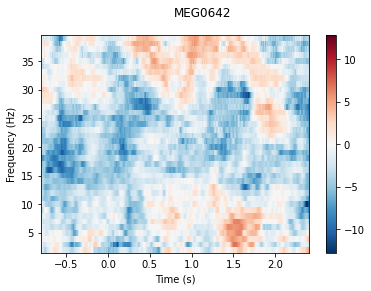

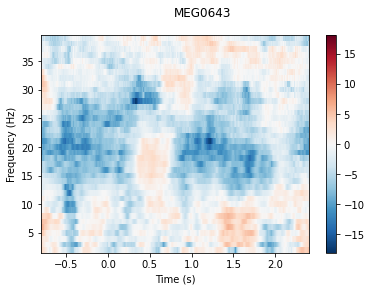

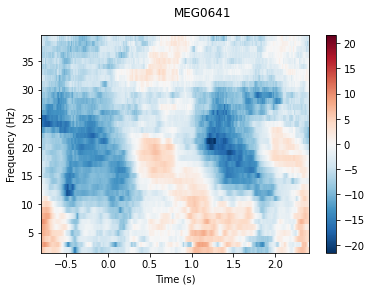

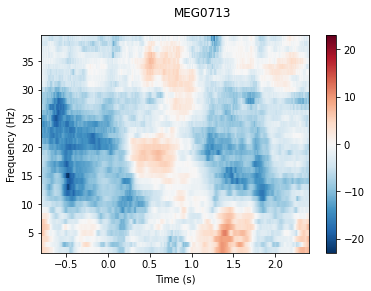

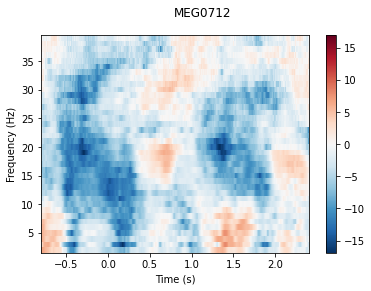

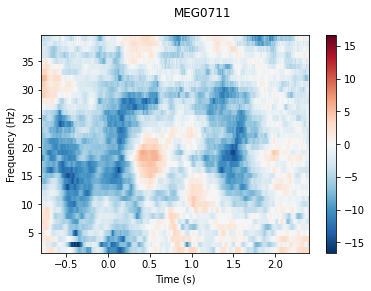

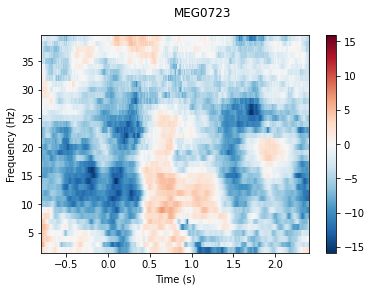

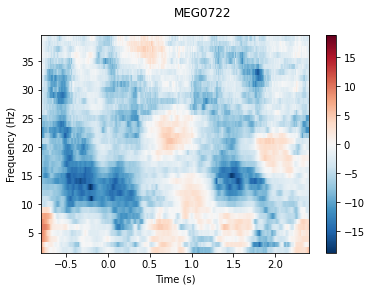

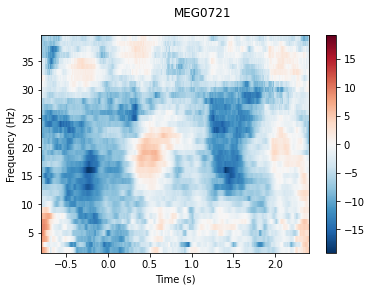

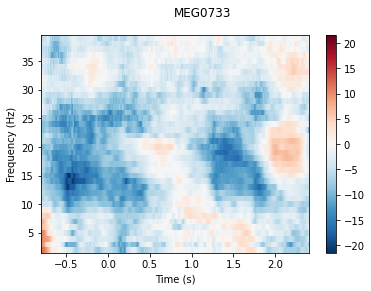

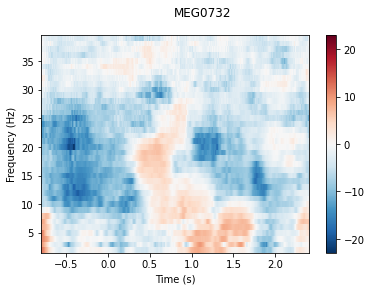

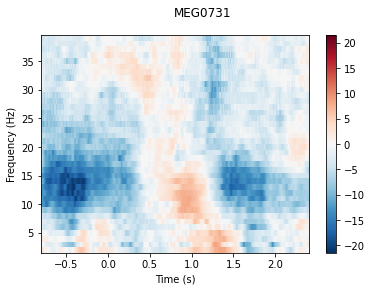

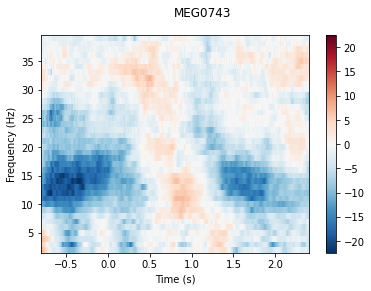

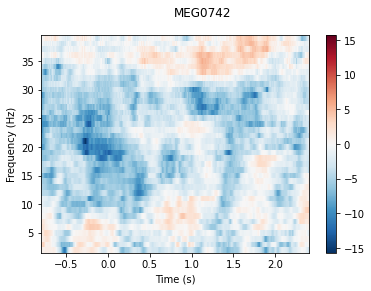

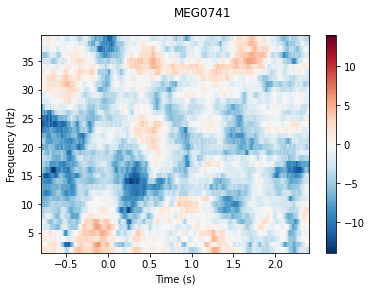

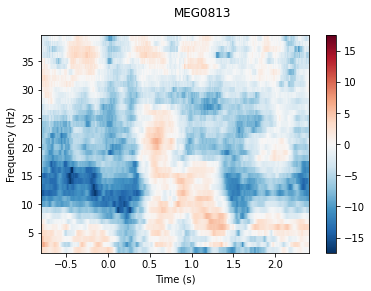

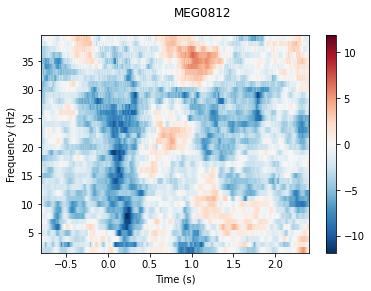

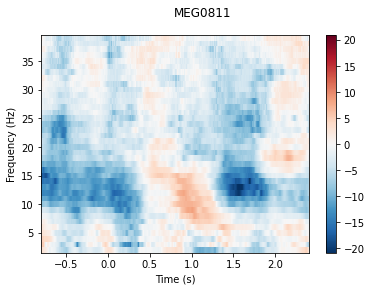

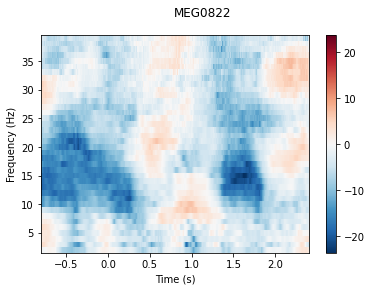

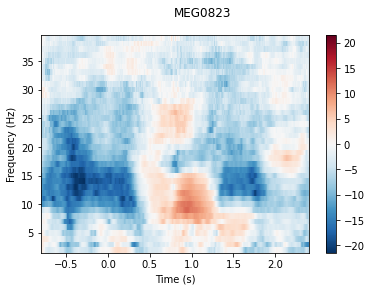

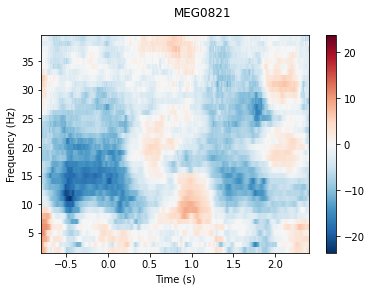

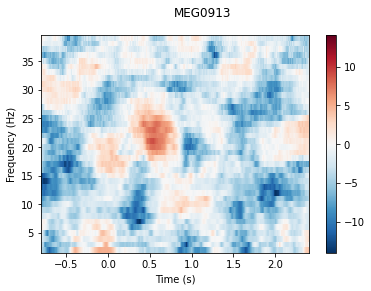

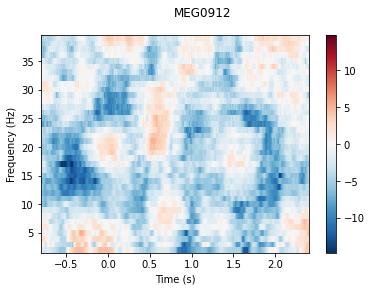

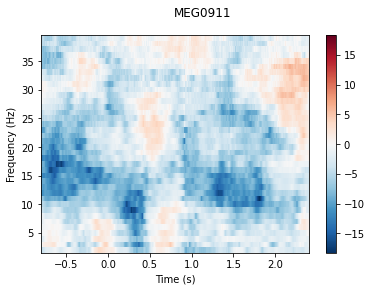

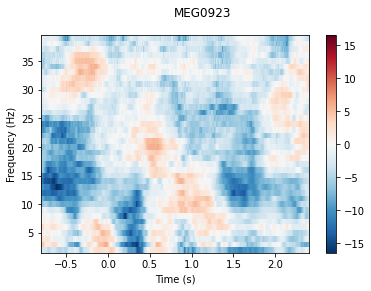

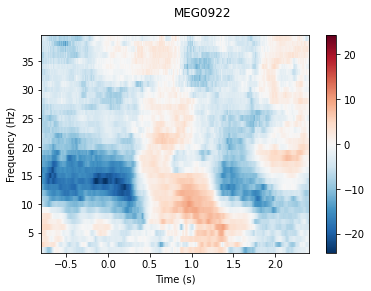

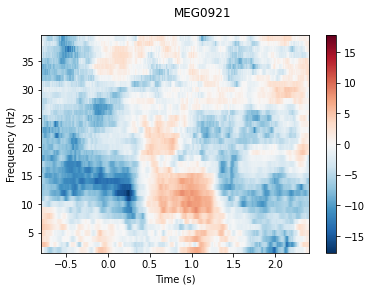

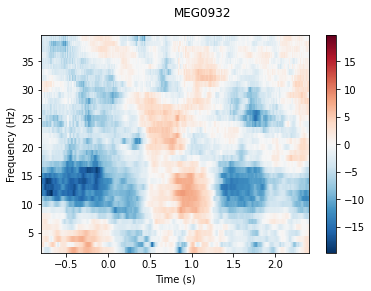

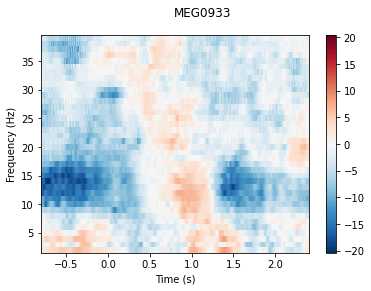

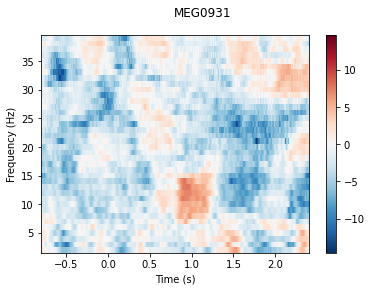

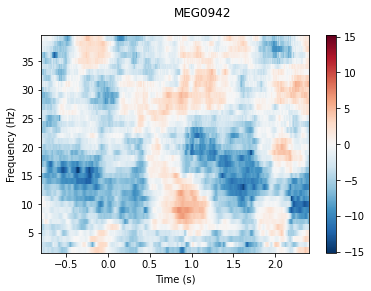

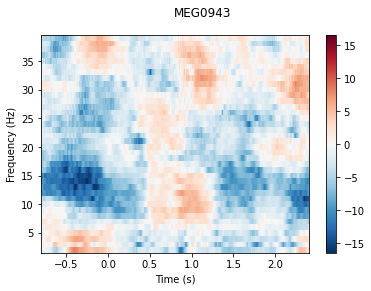

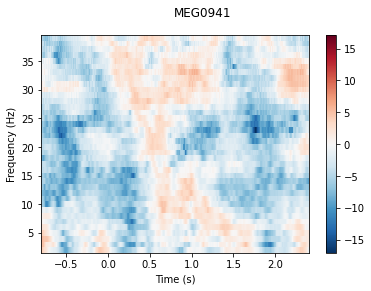

In [138]:
# получаем отдельную картинку для каждого канала
for chan in range(len(evoked.ch_names)):
	b = evoked.plot([chan], baseline=None, tmin = -0.8, tmax = 2.4, title=tfr1.ch_names[chan], show = False);
	name = '/home/vtretyakova/Рабочий стол/time_frequency_plots/channels_train/' + evoked.ch_names[chan] + '.jpeg'
	b.savefig(name, dpi=300, format='jpeg', transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None)

# check

In [56]:
ch1 = np.array([[[4, 4, 4], [4, 4, 4]], [[4, 4, 4], [4, 4, 4]]])
ch1.shape

#b = np.array([[[1, 2], [3, 4]], [[5, 6], [7, 8]], [[9, 10], [11, 12]]])

(2, 2, 3)

In [62]:
ch2 = np.array([[[1], [2]], [[3], [4]]])
#ch2 = ch2[:, np.newaxis]
ch2.shape

(2, 2, 1)

In [63]:
ch3 = ch1 - ch2
ch3

array([[[3, 3, 3],
        [2, 2, 2]],

       [[1, 1, 1],
        [0, 0, 0]]])

In [23]:
temp = freq_show.data.sum(axis=2)
temp.shape

(2, 306, 1350)

In [37]:
####### Для данных так же меняем оси местами
data = np.swapaxes(temp, 0, 1)
data.shape

(306, 2, 1350)

In [38]:
data = np.swapaxes(data, 1, 2)
data.shape

(306, 1350, 2)

In [31]:
# Усредняем бейзлайн по всем точкам, получаем одно число (которое будем вычитать из data для каждого канала)
	    
b = b_line.mean(axis=-1)
	    


In [33]:
b.shape

(306,)

In [32]:
b_line_new_shape = b[:, np.newaxis, np.newaxis]

In [34]:
b_line_new_shape.shape

(306, 1, 1)

In [40]:
data = 10*np.log10(data/b_line_new_shape)

# Усреднение

In [143]:
donor = mne.time_frequency.read_tfrs('/home/vtretyakova/Рабочий стол/time_frequency_plots/comb_planar_train_evoked.h5', condition=None)[0]
donor.data.shape

Reading /home/vtretyakova/Рабочий стол/time_frequency_plots/comb_planar_train_evoked.h5 ...


<ipython-input-143-af190ec94701>:1: RuntimeWarning: This filename (/home/vtretyakova/Рабочий стол/time_frequency_plots/comb_planar_train_evoked.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  donor = mne.time_frequency.read_tfrs('/home/vtretyakova/Рабочий стол/time_frequency_plots/comb_planar_train_evoked.h5', condition=None)[0]


Not setting metadata


(1, 102, 38, 1350)

In [145]:
n = donor.data.shape[3] 
n

1350

In [157]:
positive_fb = np.empty((0, 306, 20, n)) # эпохи х каналы х частоты х временные точки

In [158]:
positive_fb.shape

(0, 306, 20, 1350)

In [156]:
epochs_positive = mne.time_frequency.read_tfrs('/net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/tfr_plots/h5_2_40_epo/P001_run2_norisk_fb_cur_positive_h5_2_40_epo-epo.h5', condition=None)[0]


Reading /net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/tfr_plots/h5_2_40_epo/P001_run2_norisk_fb_cur_positive_h5_2_40_epo-epo.h5 ...


<ipython-input-156-665ee0654f3b>:1: RuntimeWarning: This filename (/net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/tfr_plots/h5_2_40_epo/P001_run2_norisk_fb_cur_positive_h5_2_40_epo-epo.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  epochs_positive = mne.time_frequency.read_tfrs('/net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/tfr_plots/h5_2_40_epo/P001_run2_norisk_fb_cur_positive_h5_2_40_epo-epo.h5', condition=None)[0]


Not setting metadata


In [142]:
epochs_positive.data.shape

(17, 306, 20, 1350)

In [159]:
positive_fb = np.vstack([positive_fb, epochs_positive.data])
positive_fb.shape

(17, 306, 20, 1350)

In [152]:
epochs_positive_2 = mne.time_frequency.read_tfrs('/net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/tfr_plots/h5_2_40_epo/P001_run2_postrisk_fb_cur_positive_h5_2_40_epo-epo.h5', condition=None)[0]

Reading /net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/tfr_plots/h5_2_40_epo/P001_run2_postrisk_fb_cur_positive_h5_2_40_epo-epo.h5 ...


<ipython-input-152-1cee47949adc>:1: RuntimeWarning: This filename (/net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/tfr_plots/h5_2_40_epo/P001_run2_postrisk_fb_cur_positive_h5_2_40_epo-epo.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  epochs_positive_2 = mne.time_frequency.read_tfrs('/net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/tfr_plots/h5_2_40_epo/P001_run2_postrisk_fb_cur_positive_h5_2_40_epo-epo.h5', condition=None)[0]


Not setting metadata


In [154]:
epochs_positive_2.data.shape

(1, 306, 20, 1350)

In [160]:
positive_fb = np.vstack([positive_fb, epochs_positive_2.data])
positive_fb.shape

(18, 306, 20, 1350)